In [1]:
# # Code to convert this notebook to .py if you want to run it via command line or with Slurm
# from subprocess import call
# command = "jupyter nbconvert Reconstruction_Metrics.ipynb --to python"
# call(command,shell=True)

In [2]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm import tqdm
from datetime import datetime
import argparse

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
local_rank = 0
print("device:",device)

import utils
seed=42
# utils.seed_everything(seed=seed)

if utils.is_interactive():
    %load_ext autoreload
    %autoreload 2

# from models import Clipper
# clip_extractor = Clipper("ViT-L/14", hidden_state=False, norm_embs=True, device=device)
imsize = 512

/home/ldy/miniconda3/envs/BCI/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


device: cuda:2


/home/ldy/Workspace/Generation/diffusers/src/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/home/ldy/Workspace/Generation_MEG/Generation_MEG/ATMS/generated_imgs/sub-04'
target_dir = '/home/ldy/Workspace/Generation_MEG/Generation_MEG/ATMS/generated_imgs_tensor'

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Initialize a list to hold all the image tensors
tensor_list = []
# Initialize a dictionary to map image file names to their categories
image_categories = {}

# Initialize the set to store unique category names
category_set = set()

# Iterate over the folders in the source directory
for folder_name in sorted(os.listdir(source_dir)):
    folder_path = os.path.join(source_dir, folder_name)

    # Extract the category name from the folder name (assuming category is part of folder_name)
    category_name = folder_name.split('_')[-1]  # This splits the folder_name and takes the last part as the category
    category_set.add(category_name)  # Add the category name to the set

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # Sort the image files to ensure consistent order
        image_files = sorted(os.listdir(folder_path))
        # Iterate over the sorted images in the folder
        for image_name in image_files:
            image_path = os.path.join(folder_path, image_name)

            # Map the image name to its category
            image_categories[image_name] = category_name

            # Load the image
            with Image.open(image_path) as img:
                # Convert the image to a PyTorch tensor and add a batch dimension
                tensor = torch.tensor(np.array(img)).unsqueeze(0)
                tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)

# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "all_images.pt")
torch.save(all_tensors, combined_tensor_path)

# Now we sort the category names and write them to a file
# along with their associated image names
categories_path = os.path.join(target_dir, "categories.txt")
with open(categories_path, 'w') as f:
    for image_name, category_name in sorted(image_categories.items()):
        f.write(f"{image_name}: {category_name}\n")

# Print out the category list, now sorted
category_list = sorted(list(category_set))
print(category_list)

['alligator', 'altar', 'ashtray', 'avocado', 'axe', 'baby', 'bag', 'bagel', 'ball', 'balloon', 'bamboo', 'banana', 'bassinet', 'battery', 'beachball', 'bean', 'bear', 'beaver', 'bed', 'bee', 'beer', 'bell', 'bench', 'bike', 'blind', 'blowtorch', 'boa', 'boat', 'bobsled', 'brace', 'broccoli', 'brownie', 'bulldozer', 'bullet', 'butterfly', 'camel', 'candelabra', 'candy', 'canoe', 'card', 'cardigan', 'carrier', 'cashew', 'caterpillar', 'cheese', 'cheetah', 'chest1', 'chipmunk', 'clipboard', 'closet', 'cookie', 'couch', 'cow', 'crank', 'crayon', 'crib', 'cucumber', 'cufflink', 'cupcake', 'cymbal', 'defibrillator', 'dish', 'dolly', 'donut', 'dough', 'dragonfly', 'drain', 'drawer', 'dress', 'dresser', 'earring', 'easel', 'eggbeater', 'extinguisher', 'fish', 'floss', 'flower', 'foil', 'footprint', 'fudge', 'gel', 'graffiti', 'grape', 'grate', 'guacamole', 'guardrail', 'hairbrush', 'hay', 'headlamp', 'headphones', 'hedgehog', 'helicopter', 'helmet', 'hippopotamus', 'hoop', 'horse', 'horseshoe'

In [4]:
import os
from PIL import Image
import torch
import numpy as np

# Define the source and target directories
source_dir = '/home/ldy/Workspace/THINGS/osfstorage/THINGS/images_set/test_images/images'
target_dir = '/home/ldy/Workspace/THINGS/osfstorage/THINGS/images_set/images_tensor'

# Create the target directory if it doesn't exist
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Initialize a list to hold all the image tensors
tensor_list = []
# Initialize a dictionary to map image file names to their categories
image_categories = {}
# Initialize the set to store unique category names
category_set = set()

# Define a common size for all images
common_size = (224, 224)  # You can adjust this to the desired size

# Iterate over the folders in the source directory
for folder_name in sorted(os.listdir(source_dir)):
    folder_path = os.path.join(source_dir, folder_name)
    # Extract the category name from the folder name
    category_name = folder_name.split('_')[-1]
    category_set.add(category_name)

    if os.path.isdir(folder_path):
        image_files = sorted(os.listdir(folder_path))
        for image_name in image_files:
            image_path = os.path.join(folder_path, image_name)
            image_categories[image_name] = category_name

            with Image.open(image_path) as img:
                # Resize the image to the common size
                img = img.resize(common_size)
                # Convert the image to a PyTorch tensor and add a batch dimension
                tensor = torch.tensor(np.array(img)).unsqueeze(0)
                tensor_list.append(tensor)

# Concatenate all tensors along the 0th dimension
all_tensors = torch.cat(tensor_list, dim=0)

# Save the combined tensor
combined_tensor_path = os.path.join(target_dir, "all_images.pt")
torch.save(all_tensors, combined_tensor_path)

# Save the category list to a text file
categories_path = os.path.join(target_dir, "categories.txt")
with open(categories_path, 'w') as f:
    for image_name, category_name in sorted(image_categories.items()):
        f.write(f"{image_name}: {category_name}\n")

# Print out the category list
category_list = sorted(list(category_set))
print(category_list)

['alligator', 'altar', 'ashtray', 'avocado', 'axe', 'baby', 'bag', 'bagel', 'ball', 'balloon', 'bamboo', 'banana', 'bassinet', 'battery', 'beachball', 'bean', 'bear', 'beaver', 'bed', 'bee', 'beer', 'bell', 'bench', 'bike', 'blind', 'blowtorch', 'boa', 'boat', 'bobsled', 'brace', 'broccoli', 'brownie', 'bulldozer', 'bullet', 'butterfly', 'camel', 'candelabra', 'candy', 'canoe', 'card', 'cardigan', 'carrier', 'cashew', 'caterpillar', 'cheese', 'cheetah', 'chest1', 'chipmunk', 'clipboard', 'closet', 'cookie', 'couch', 'cow', 'crank', 'crayon', 'crib', 'cucumber', 'cufflink', 'cupcake', 'cymbal', 'defibrillator', 'dish', 'dolly', 'donut', 'dough', 'dragonfly', 'drain', 'drawer', 'dress', 'dresser', 'earring', 'easel', 'eggbeater', 'extinguisher', 'fish', 'floss', 'flower', 'foil', 'footprint', 'fudge', 'gel', 'graffiti', 'grape', 'grate', 'guacamole', 'guardrail', 'hairbrush', 'hay', 'headlamp', 'headphones', 'hedgehog', 'helicopter', 'helmet', 'hippopotamus', 'hoop', 'horse', 'horseshoe'

# Configurations

In [5]:
# # if running this interactively, can specify jupyter_args here for argparser to use
# if utils.is_interactive():
#     # Example use
#     jupyter_args = "--recon_path=prior_257_final_subj01_bimixco_softclip_byol_brain_recons_full_img2img0.85_16samples.pt"
    
#     jupyter_args = jupyter_args.split()
#     print(jupyter_args)

In [6]:
# parser = argparse.ArgumentParser(description="Model Training Configuration")
# parser.add_argument(
#     "--recon_path", type=str,
#     help="path to reconstructed/retrieved outputs",
# )
# parser.add_argument(
#     "--all_images_path", type=str, default="all_images.pt",
#     help="path to ground truth outputs",
# )

# if utils.is_interactive():
#     args = parser.parse_args(jupyter_args)
# else:
#     args = parser.parse_args()

# # create global variables without the args prefix
# for attribute_name in vars(args).keys():
#     globals()[attribute_name] = getattr(args, attribute_name)

In [7]:
recon_path = '/home/ldy/Workspace/Generation_MEG/Generation_MEG/ATMS/generated_imgs_tensor/all_images.pt'
all_images_path = '/home/ldy/Workspace/THINGS/osfstorage/THINGS/images_set/images_tensor/all_images.pt'
all_brain_recons = torch.load(f'{recon_path}')
all_images = torch.load(f'{all_images_path}')
all_brain_recons = all_brain_recons


all_images = all_images.to(device)

all_images = all_images.transpose(1, 3)
all_images = all_images.transpose(2, 3)
all_brain_recons = all_brain_recons.transpose(1, 3)
all_brain_recons = all_brain_recons.transpose(2, 3)
print(all_images.shape)
print(all_brain_recons.shape)

torch.Size([200, 3, 224, 224])
torch.Size([200, 3, 512, 512])


In [8]:
print("Minimum:", all_brain_recons.min().item())
print("Maximum:", all_brain_recons.max().item())
print("Mean:", all_brain_recons.to(dtype=torch.float32).mean().item())

Minimum: 0
Maximum: 255
Mean: 129.299072265625


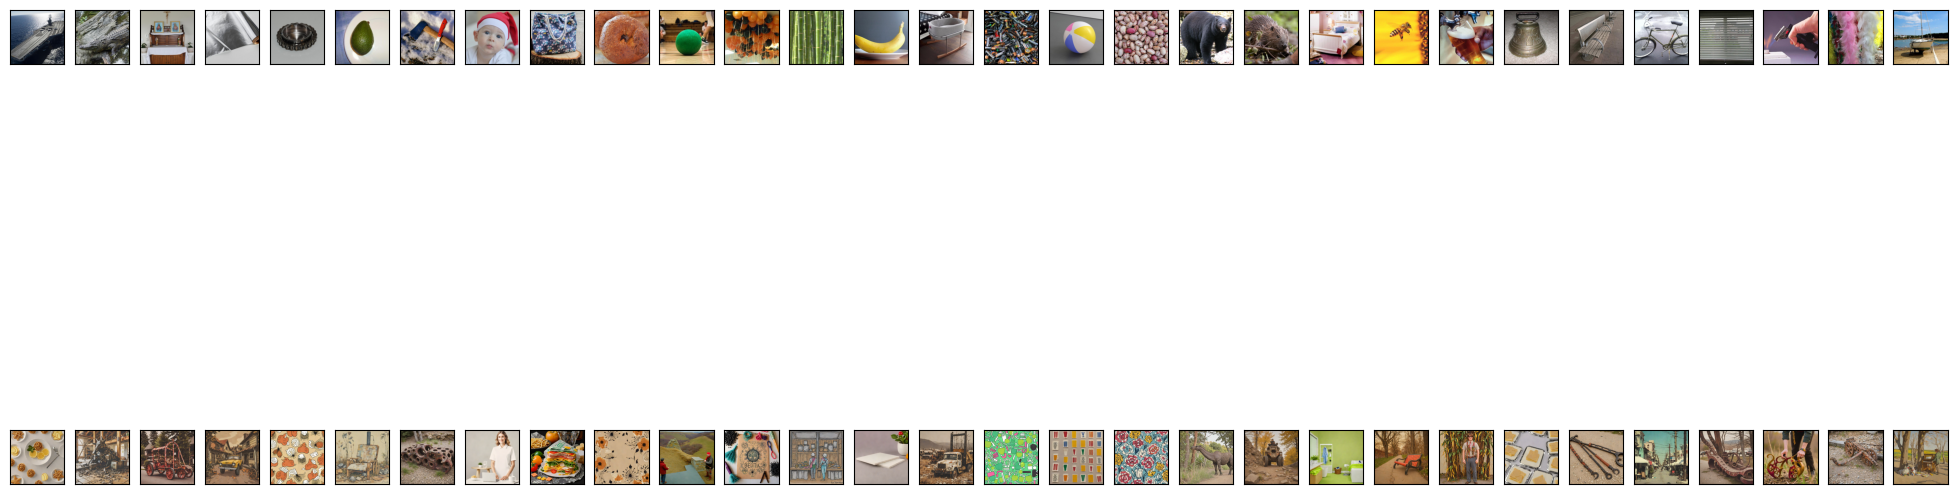

In [9]:
fig, axs = plt.subplots(2, 30, figsize=(25, 10))


for i in range(30):
    img = all_images[i].detach()
    img = transforms.ToPILImage()(img)
    axs[0, i].imshow(np.asarray(img))
    axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


for i in range(30):
    img = all_brain_recons[i].detach()
    img = transforms.ToPILImage()(img)
    axs[1, i].imshow(np.asarray(img))
    axs[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.show()

# Display reconstructions next to ground truth images

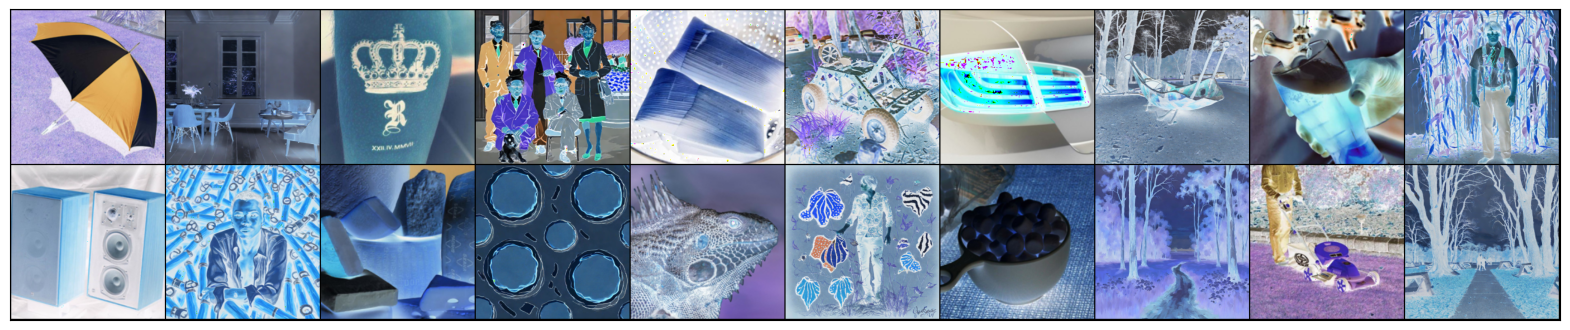

In [10]:
imsize = 256
all_images = transforms.Resize((imsize,imsize))(all_images)
all_brain_recons = transforms.Resize((imsize,imsize))(all_brain_recons)

np.random.seed(0)
ind = np.flip(np.array([112,119,101,44,159,22,173,174,175,189]))

all_interleaved = torch.zeros(len(ind)*2,3,imsize,imsize)
icount = 0
for t in ind:
    all_interleaved[icount] = all_images[t]
    all_interleaved[icount+1] = all_brain_recons[t]
    icount += 2

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs,figsize):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = transforms.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
grid = make_grid(all_interleaved, nrow=10, padding=2)
show(grid,figsize=(20,16))

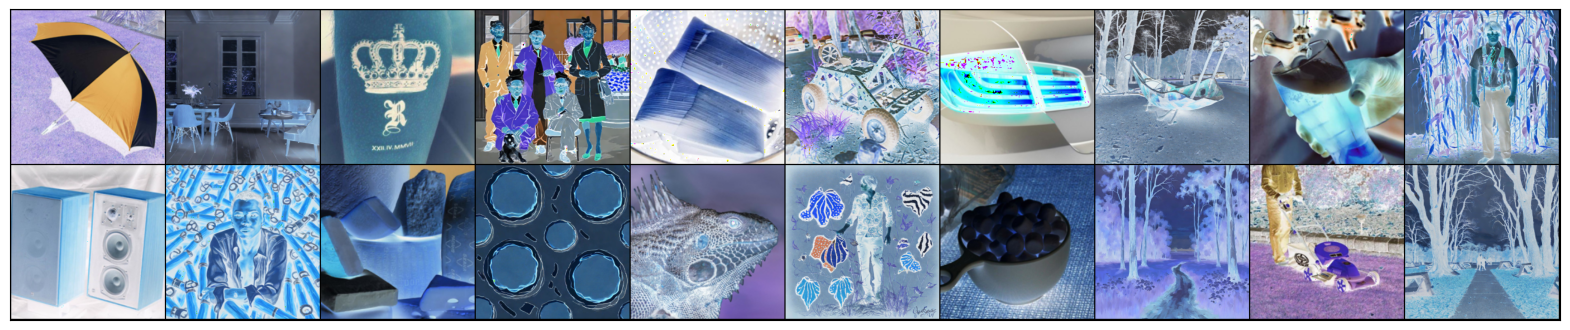

In [11]:
import torch
from torchvision import transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# Assume all_images and all_brain_recons are defined and are lists or datasets of images
batch_size = 10  # Adjust batch_size depending on your GPU memory
num_batches = int(np.ceil(len(ind) / batch_size))
ind = np.flip(np.array([112,119,101,44,159,22,173,174,175,189]))
for batch_idx in range(num_batches):
    batch_start = batch_idx * batch_size
    batch_end = min(batch_start + batch_size, len(ind))
    batch_indices = ind[batch_start:batch_end]

    all_interleaved = torch.zeros(len(batch_indices)*2, 3, imsize, imsize)

    icount = 0
    for t in batch_indices:
        img = transforms.Resize((imsize, imsize))(all_images[t])
        recon = transforms.Resize((imsize, imsize))(all_brain_recons[t])

        all_interleaved[icount] = img
        all_interleaved[icount + 1] = recon
        icount += 2

    # Show or save the processed images here
    grid = make_grid(all_interleaved, nrow=10, padding=2)
    show(grid, figsize=(20, 16))

    # Optional: Clear cache if you are still facing memory issues
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# 2-Way Identification

In [12]:
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

@torch.no_grad()
def two_way_identification(all_brain_recons, all_images, model, preprocess, feature_layer=None, return_avg=True):
    preds = model(torch.stack([preprocess(recon) for recon in all_brain_recons], dim=0).to(device))
    reals = model(torch.stack([preprocess(indiv) for indiv in all_images], dim=0).to(device))
    if feature_layer is None:
        preds = preds.float().flatten(1).cpu().numpy()
        reals = reals.float().flatten(1).cpu().numpy()
    else:
        preds = preds[feature_layer].float().flatten(1).cpu().numpy()
        reals = reals[feature_layer].float().flatten(1).cpu().numpy()

    r = np.corrcoef(reals, preds)
    r = r[:len(all_images), len(all_images):]
    congruents = np.diag(r)

    success = r < congruents
    success_cnt = np.sum(success, 0)

    if return_avg:
        perf = np.mean(success_cnt) / (len(all_images)-1)
        return perf
    else:
        return success_cnt, len(all_images)-1

## PixCorr

In [13]:
# preprocess = transforms.Compose([
#     transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
# ])

# # Flatten images while keeping the batch dimension
# all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
# all_brain_recons_flattened = preprocess(all_brain_recons).view(len(all_brain_recons), -1).cpu()

# print(all_images_flattened.shape)
# print(all_brain_recons_flattened.shape)

# corrsum = 0
# for i in tqdm(range(982)):
#     corrsum += np.corrcoef(all_images_flattened[i], all_brain_recons_flattened[i])[0][1]
# corrmean = corrsum / 982

# pixcorr = corrmean
# print(pixcorr)

In [14]:
from torchvision import transforms
from tqdm import tqdm
import numpy as np

# Define the preprocessing transformation
preprocess = transforms.Compose([
    transforms.Resize((425, 425), interpolation=transforms.InterpolationMode.BILINEAR),
])

# Assuming all_images and all_brain_recons are tensors of images
# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(all_images).reshape(len(all_images), -1).cpu()
all_brain_recons_flattened = preprocess(all_brain_recons).reshape(len(all_brain_recons), -1).cpu()

print(all_images_flattened.shape)
print(all_brain_recons_flattened.shape)

corrsum = 0
# Ensure you iterate over the correct range, depending on the number of images
for i in tqdm(range(len(all_images_flattened))):
    corrsum += np.corrcoef(all_images_flattened[i].numpy(), all_brain_recons_flattened[i].numpy())[0][1]
corrmean = corrsum / len(all_images_flattened)

pixcorr = corrmean
print(pixcorr)

torch.Size([200, 541875])
torch.Size([200, 541875])


100%|██████████| 200/200 [00:00<00:00, 607.86it/s]

0.0919374680578255


## SSIM

In [15]:
# see https://github.com/zijin-gu/meshconv-decoding/issues/3
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

# convert image to grayscale with rgb2grey
img_gray = rgb2gray(preprocess(all_images).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(all_brain_recons).permute((0,2,3,1)).cpu())
print("converted, now calculating ssim...")

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray),total=len(all_images)):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

converted, now calculating ssim...


100%|██████████| 200/200 [00:02<00:00, 88.41it/s]

0.3143518864883131


### AlexNet

In [16]:
# from torchvision.models import alexnet, AlexNet_Weights
# alex_weights = AlexNet_Weights.IMAGENET1K_V1

# alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4','features.11']).to(device)
# alex_model.eval().requires_grad_(False)

# # see alex_weights.transforms()
# preprocess = transforms.Compose([
#     transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])

# layer = 'early, AlexNet(2)'
# print(f"\n---{layer}---")
# all_per_correct = two_way_identification(all_brain_recons.to(device).float(), all_images, 
#                                                           alex_model, preprocess, 'features.4')
# alexnet2 = np.mean(all_per_correct)
# print(f"2-way Percent Correct: {alexnet2:.4f}")

# layer = 'mid, AlexNet(5)'
# print(f"\n---{layer}---")
# all_per_correct = two_way_identification(all_brain_recons.to(device).float(), all_images, 
#                                                           alex_model, preprocess, 'features.11')
# alexnet5 = np.mean(all_per_correct)
# print(f"2-way Percent Correct: {alexnet5:.4f}")

In [20]:
import torch
from torchvision import transforms
from torchvision.models import alexnet, AlexNet_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm import tqdm
import numpy as np

# Assuming device is defined (e.g., device = torch.device("cuda") for GPU)
device = torch.device("cuda:3")

# Initialize the AlexNet model
alex_weights = AlexNet_Weights.IMAGENET1K_V1
alex_model = create_feature_extractor(alexnet(weights=alex_weights), return_nodes=['features.4', 'features.11']).to(device)
alex_model.eval().requires_grad_(False)

# Define the preprocess function without ToTensor()
preprocess = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(lambda x: x.float() / 255),  # Ensure scaling is applied
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Usage example
layer = 'early, AlexNet(2)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_brain_recons.to(device), all_images, alex_model, preprocess, 'features.4')
alexnet2 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet2:.4f}")

layer = 'mid, AlexNet(5)'
print(f"\n---{layer}---")
all_per_correct = two_way_identification(all_brain_recons.to(device), all_images, alex_model, preprocess, 'features.11')
alexnet5 = np.mean(all_per_correct)
print(f"2-way Percent Correct: {alexnet5:.4f}")


---early, AlexNet(2)---
2-way Percent Correct: 0.5805

---mid, AlexNet(5)---
2-way Percent Correct: 0.6105


### InceptionV3

In [18]:
from torchvision.models import inception_v3, Inception_V3_Weights
weights = Inception_V3_Weights.DEFAULT
inception_model = create_feature_extractor(inception_v3(weights=weights), 
                                           return_nodes=['avgpool']).to(device)
inception_model.eval().requires_grad_(False)

# see weights.transforms()
preprocess = transforms.Compose([
    transforms.Resize(342, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(lambda x: x.float() / 255),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

all_per_correct = two_way_identification(all_brain_recons, all_images,
                                        inception_model, preprocess, 'avgpool')
        
inception = np.mean(all_per_correct)
print(f"2-way Percent Correct: {inception:.4f}")

/home/ldy/miniconda3/envs/BCI/lib/python3.10/site-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


2-way Percent Correct: 0.5836


### CLIP

In [19]:
import clip
clip_model, preprocess = clip.load("ViT-L/14", device=device)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(lambda x: x.float() / 255),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                         std=[0.26862954, 0.26130258, 0.27577711]),
])

all_per_correct = two_way_identification(all_brain_recons, all_images,
                                        clip_model.encode_image, preprocess, None) # final layer
clip_ = np.mean(all_per_correct)
print(f"2-way Percent Correct: {clip_:.4f}")

2-way Percent Correct: 0.6016


### Efficient Net

In [22]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
# weights = EfficientNet_B1_Weights.DEFAULT
# eff_model = create_feature_extractor(efficientnet_b1(weights=weights), 
#                                     return_nodes=['avgpool']).to(device)
# eff_model.eval().requires_grad_(False)

# # see weights.transforms()
# preprocess = transforms.Compose([
#     transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])

# gt = eff_model(preprocess(all_images))['avgpool']
# gt = gt.reshape(len(gt),-1).cpu().numpy()
# fake = eff_model(preprocess(all_brain_recons))['avgpool']
# fake = fake.reshape(len(fake),-1).cpu().numpy()

# effnet = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
# print("Distance:",effnet)

In [23]:
import torch
from torchvision import transforms, models
from torchvision.models.feature_extraction import create_feature_extractor
import numpy as np
import scipy as sp

# Assuming device is defined (e.g., device = torch.device("cuda") for GPU)
device = torch.device("cuda:4")

# Initialize the EfficientNet model
weights = models.EfficientNet_B1_Weights.DEFAULT
eff_model = create_feature_extractor(efficientnet_b1(weights=weights), return_nodes=['avgpool']).to(device)
eff_model.eval().requires_grad_(False)

# Define the preprocess function
preprocess = transforms.Compose([
    transforms.Resize(255, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(lambda x: x.float() / 255),  # Ensure scaling is applied
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Process all_images
gt = eff_model(torch.stack([preprocess(img.float() / 255) for img in all_images.to(device)], dim=0))['avgpool']
gt = gt.reshape(len(gt), -1).cpu().numpy()

# Process all_brain_recons
fake = eff_model(torch.stack([preprocess(recon.float() / 255) for recon in all_brain_recons.to(device)], dim=0))['avgpool']
fake = fake.reshape(len(fake), -1).cpu().numpy()

# Calculate the correlation distance
effnet = np.array([sp.spatial.distance.correlation(gt[i], fake[i]) for i in range(len(gt))]).mean()
print("Distance:", effnet)

Distance: 0.786254261284921


### SwAV

In [ ]:
# swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
# swav_model = create_feature_extractor(swav_model, 
#                                     return_nodes=['avgpool']).to(device)
# swav_model.eval().requires_grad_(False)

# preprocess = transforms.Compose([
#     transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225]),
# ])

# gt = swav_model(preprocess(all_images))['avgpool']
# gt = gt.reshape(len(gt),-1).cpu().numpy()
# fake = swav_model(preprocess(all_brain_recons))['avgpool']
# fake = fake.reshape(len(fake),-1).cpu().numpy()

# swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
# print("Distance:",swav)

In [24]:
import torch
import torch.hub
from torchvision import transforms
from torchvision.models.feature_extraction import create_feature_extractor
import numpy as np
import scipy as sp

# Assuming device is defined (e.g., device = torch.device("cuda") for GPU)
device = torch.device("cuda:3")

# Initialize the SWaV model
swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, return_nodes=['avgpool']).to(device)
swav_model.eval().requires_grad_(False)

# Define the preprocess function
preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(lambda x: x.float() / 255),  # Ensure scaling is applied
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Process all_images
gt = swav_model(torch.stack([preprocess(img.float() / 255) for img in all_images.to(device)], dim=0))['avgpool']
gt = gt.reshape(len(gt), -1).cpu().numpy()

# Process all_brain_recons
fake = swav_model(torch.stack([preprocess(recon.float() / 255) for recon in all_brain_recons.to(device)], dim=0))['avgpool']
fake = fake.reshape(len(fake), -1).cpu().numpy()

# Calculate the correlation distance
swav = np.array([sp.spatial.distance.correlation(gt[i], fake[i]) for i in range(len(gt))]).mean()
print("Distance:", swav)

Using cache found in /home/ldy/.cache/torch/hub/facebookresearch_swav_main
/home/ldy/miniconda3/envs/BCI/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ldy/miniconda3/envs/BCI/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance: 0.21728565871715547


# Display in table

In [25]:
# Create a dictionary to store variable names and their corresponding values
data = {
    "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV"],
    "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav],
}

df = pd.DataFrame(data)
print(df.to_string(index=False))

if not utils.is_interactive():
    # save table to txt file
    df.to_csv(f'{recon_path[:-3]}.csv', sep='\t', index=False)

     Metric    Value
    PixCorr 0.091937
       SSIM 0.314352
 AlexNet(2) 0.580503
 AlexNet(5) 0.610528
InceptionV3 0.583618
       CLIP 0.601608
   EffNet-B 0.786254
       SwAV 0.217286
